In [2]:
import numpy as np
import control
import control.matlab

# # Define the system dynamics
# R1 = 2e3
# C1 = 1e-6
# R2 = 1e3
# C2 = 1e-6

# TP
R1 = 2.2e3
C1 = 1e-6
R2 = 1e2
C2 = 1e-6

A = np.array([[-(1/R1+1/R2)/C1, 1/(R2*C1)], [1/(R2*C2), -1/(R2*C2)]])
B = np.array([[1/(R1*C1)], [0]])
C = np.array([[0, 1]])

sys = control.ss(A,B,C,0)

# Define the simulation time and sampling time
h = 1e-3 
T = 1
t = np.linspace(0, T, int(T/h))

sysd = control.matlab.c2d(sys,h)

In [3]:
# Define a function to calculate the rise time
def calculate_rise_time(signal, time,ref_value=1):
    # Find the index where the signal first crosses the start threshold
    start_index = np.argmax(signal >= 0.1*ref_value)
    
    # Find the index where the signal crosses the end threshold
    end_index = np.argmax(signal >= 0.9*ref_value)
    
    # Calculate the rise time as the difference between the two indices, multiplied by the time step
    rise_time = time[end_index] - time[start_index]
    
    return rise_time

In [6]:
# Define the cost matrices for LQR
Q = np.diag([10, 10])
R = np.diag([15])

# Compute the LQR gain matrix K
K, S, E = control.dlqr(sysd, Q, R)


# Define the reference trajectory
amp = 1
t_step = 0.5
r = np.zeros(len(t))
r[t >= t_step] = amp

# Simulate the open-loop system
x = np.zeros((2, len(t)))
y = np.zeros((len(t),1))

# Simulate the closed-loop system
x_cl = np.zeros((2, len(t)))
y_cl = np.zeros((len(t),1))
u_cl = np.zeros((len(t),1))


# Initial conditions
x0 = np.array([0, 0])
x_cl[:, 0] = x0

g = sysd.C*(np.eye(2)-(sysd.A-sysd.B*K))**(-1)*sysd.B
K0 = 1/g

print("Ganancias K:  ",K,"\n Ganancia K0: ",K0)

Ganancias K:   [[0.21760338 0.2226051 ]] 
 Ganancia K0:  [[1.44020847]]


Tiempo de subida en LA: 0.010010010010010006
Tiempo de subida en LC: 0.006006006006005982
Mejora en %: -40.00000000000022


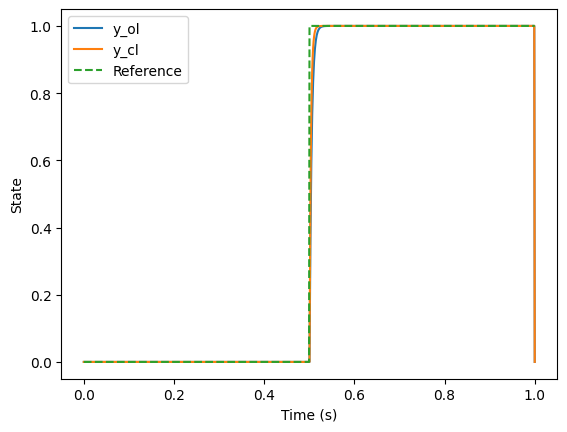

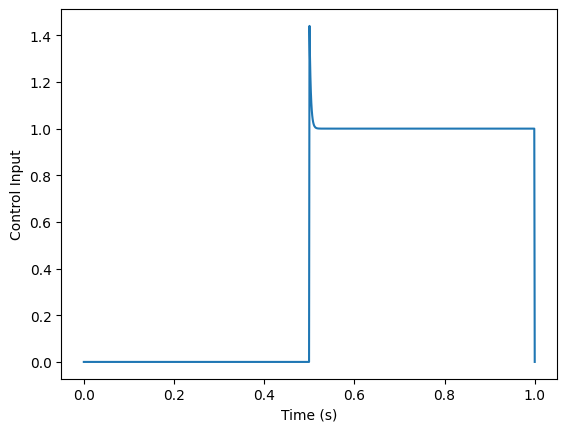

In [5]:
# Simulation and plots

for i in range(len(t)-1):
    x[:, i+1:i+2] = np.matmul(sysd.A,x[:, i:i+1]) + sysd.B*r[i]
    y[i] = np.matmul(sysd.C,x[:, i])
    
    x_cl[:, i+1:i+2] = np.matmul(sysd.A,x_cl[:, i:i+1]) + np.matmul(sysd.B,K0*r[i]-np.matmul(K, x_cl[:, i]))
    y_cl[i] = np.matmul(sysd.C,x_cl[:, i])
    u_cl[i] = K0*r[i]-np.matmul(K, x_cl[:, i])
    
    
rt = calculate_rise_time(y,t)
rt_cl = calculate_rise_time(y_cl,t)
print('Tiempo de subida en LA:',rt)
print('Tiempo de subida en LC:',rt_cl)
print('Mejora en %:',100*(rt_cl-rt)/rt)

# Plot the results
import matplotlib.pyplot as plt
# %matplotlib notebook
plt.figure()
plt.plot(t, y, label='y_ol')
plt.plot(t, y_cl, label='y_cl')
plt.plot(t, r, '--', label='Reference')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()

plt.figure()
plt.plot(t, u_cl)
plt.xlabel('Time (s)')
plt.ylabel('Control Input')
plt.show()